In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne, load_dataset
from datetime import datetime

In [10]:
#Loading the non-duplicate adult patient encounter dataset
adlt_ND_boolean = pd.read_csv("091023adlt_ND_boolean.csv")
#Loading the RSV NM EDW with all patient encounters
master_EDW = pd.read_csv("022423-EDW.csv", encoding='latin-1')
#Loading REDCap report w/ subtype info
rsv_subtype_metadata = pd.read_csv("081523-RSVID.csv")

/var/folders/3n/4ymlf6h176q558ggsk_z_7nw0000gn/T/ipykernel_603/3325192540.py:4: DtypeWarning: Columns (7,47,48,62,63,64,66,71,76,77,78,80) have mixed types. Specify dtype option on import or set low_memory=False.
  master_EDW = pd.read_csv("022423-EDW.csv", encoding='latin-1')


# Figure 2C Weekly Cases in Northwestern Medicine (NM) Systems

In [11]:
count = master_EDW.groupby('Date_of_Flu_Lab').size().rename('Count')
countdf = count.to_frame().reset_index()
countdf['Date_of_Flu_Lab'] = pd.to_datetime(countdf['Date_of_Flu_Lab'])
#Indexing dates of the RSV labs
countdf.set_index('Date_of_Flu_Lab', inplace=True)

countdf_week = countdf.resample('W').sum
print(countdf_week)

<bound method _add_downsample_kernel.<locals>.f of <pandas.core.resample.DatetimeIndexResampler object at 0x7f7d5c19d5e0>>


([<matplotlib.axis.XTick at 0x7f7d2e62bee0>,
 [Text(14335.0, 0, '2009'),
  Text(14698.0, 0, '2010'),
  Text(15061.0, 0, '2011'),
  Text(15424.0, 0, '2012'),
  Text(15787.0, 0, '2013'),
  Text(16150.0, 0, '2014'),
  Text(16513.0, 0, '2015'),
  Text(16876.0, 0, '2016'),
  Text(17239.0, 0, '2017'),
  Text(17602.0, 0, '2018'),
  Text(17965.0, 0, '2019'),
  Text(18328.0, 0, '2020'),
  Text(18691.0, 0, '2021'),
  Text(19054.0, 0, '2022'),
  Text(19417.0, 0, '2023')])

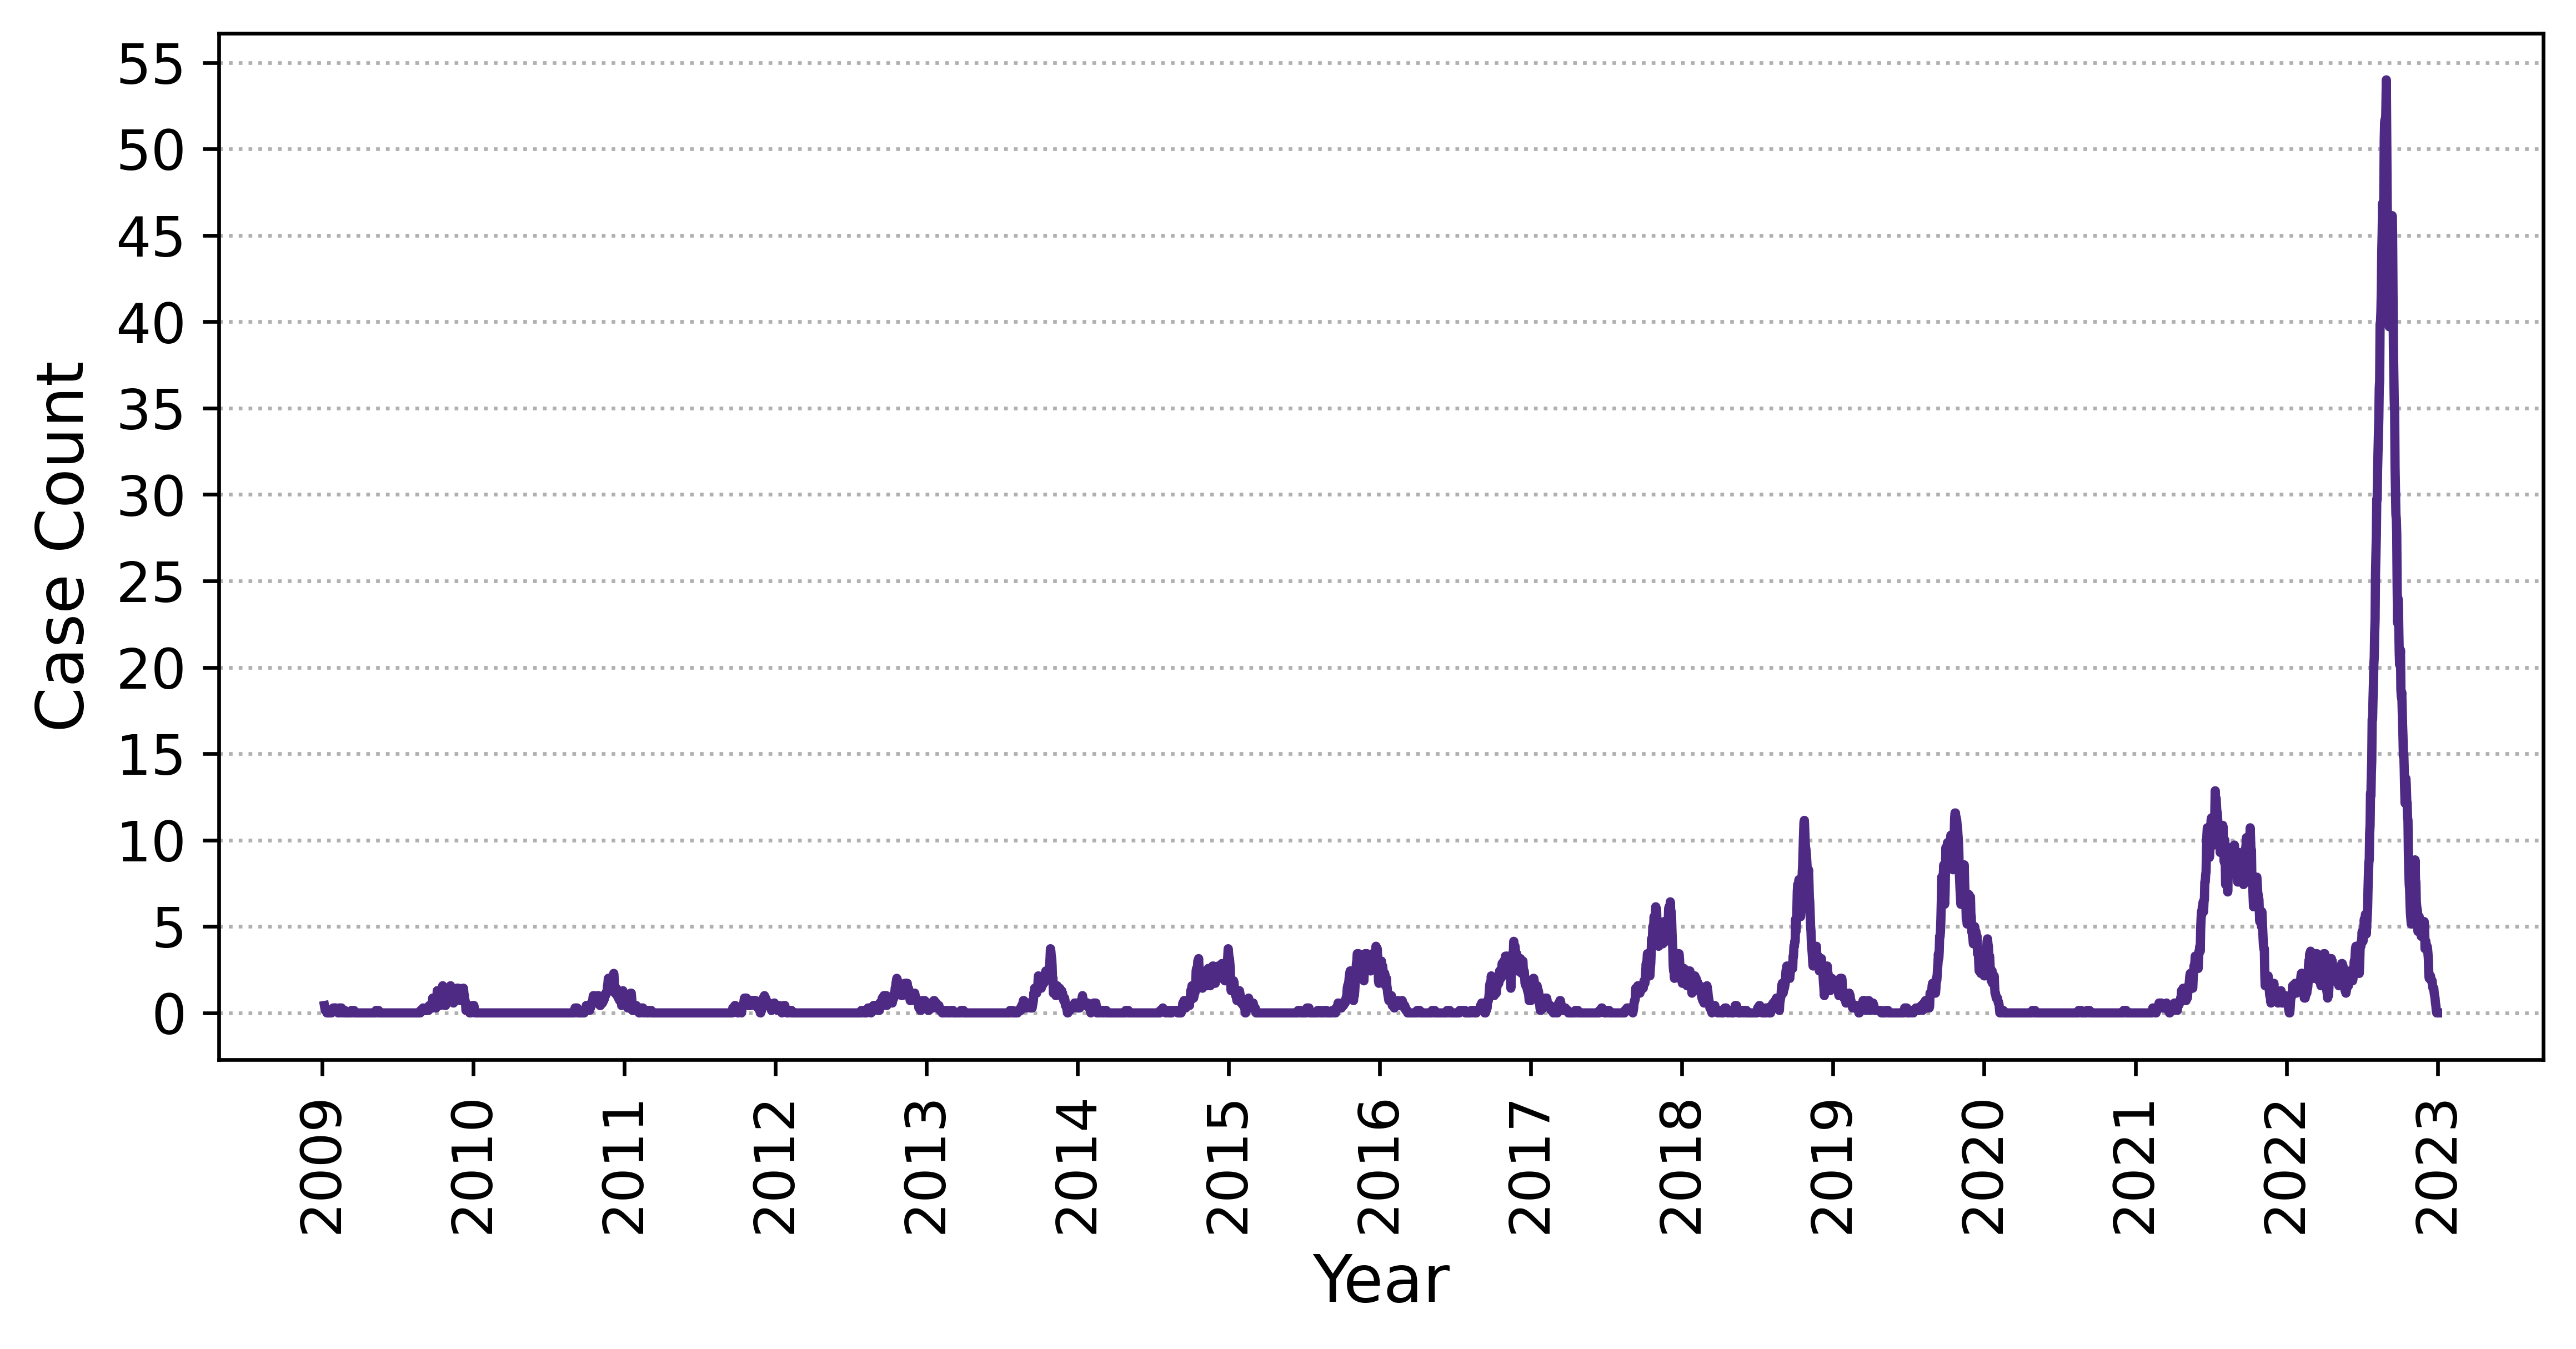

In [12]:
plt.rcParams.update({'font.size': 12})
#reindexing to populate days that do not contain case count
new_date_range = pd.date_range(start="2009-04-01", end="2023-03-01", freq="D")
#Mapping out 7 day moving average for EDW Report (irregardless of inpatient v. outpatient etc etc)
master_EDW['Date_of_Flu_Lab'] = pd.to_datetime(master_EDW['Date_of_Flu_Lab'])
total = master_EDW.groupby(['Date_of_Flu_Lab']).size()
total
ind_date0 = total.reindex(new_date_range, fill_value=0)
ind_date0
roll_date0 = ind_date0.rolling(window=7).mean()
roll_date0

plt.figure(figsize=(9,4))
ax = plt.plot(roll_date0,linewidth=2, color = '#4E2A84')
plt.rcParams['figure.dpi']=600

plt.ylabel('Case Count', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis = 'y', ls='dotted') 

plt.locator_params(axis='y', nbins=12)


num_xticks = 14
step = len(roll_date0) // num_xticks
years = roll_date0.index[::step]
plt.xticks(ticks=years, labels=years.strftime('%Y'), rotation=90) 

#plt.savefig('082823-rolling-case-count.svg', format='svg', bbox_inches='tight')

# Figure 2E Inpatient/Outpatient Ratios 

In [13]:
#change Date_of_Flu_Lab to datetime for EDW report 
adlt_ND_boolean['birth_date'] = pd.to_datetime(adlt_ND_boolean['birth_date'])
# Convert the column to datetime format
adlt_ND_boolean['Date_of_Flu_Lab'] = pd.to_datetime(adlt_ND_boolean['Date_of_Flu_Lab'])

# Format datetime column as month-day-year
adlt_ND_boolean['Date_of_Flu_Lab'] = adlt_ND_boolean['Date_of_Flu_Lab'].dt.strftime("%m-%d-%Y")
# Convert the column to datetime format
adlt_ND_boolean['Date_of_Flu_Lab'] = pd.to_datetime(adlt_ND_boolean['Date_of_Flu_Lab'])

adlt_ND_boolean['Date_of_Flu_Lab'] = pd.to_datetime(adlt_ND_boolean['Date_of_Flu_Lab'])
rsv_subtype_metadata['sample_date'] = pd.to_datetime(rsv_subtype_metadata['sample_date'])

#Changing data type for west_mrn
rsv_subtype_metadata['west_mrn'] = rsv_subtype_metadata['west_mrn'].apply(lambda x: '{:.0f}'.format(x))
adlt_ND_boolean['west_mrn'] = adlt_ND_boolean['west_mrn'].apply(lambda x: '{:.0f}'.format(x))

In [14]:
#Establishing a category for each of the patients
adlt_ND_boolean['Category'] =''

#Populating an outpatient category for individuals who were not inpatient nor ICU admits and did not experience
#an RSV associated death
adlt_ND_boolean['Category'] = np.where((adlt_ND_boolean['ICU'] == 0) & (adlt_ND_boolean['RSV_att_dth'] == '0') & (adlt_ND_boolean['encntr_type_class_dsc'] != 'Inpatient'), 'Outpatient', adlt_ND_boolean['Category'])

#Populating an inpatient category for individuals who had an inpatient encounter
adlt_ND_boolean['Category'] = np.where((adlt_ND_boolean['encntr_type_class_dsc'] == 'Inpatient'), 'Inpatient', adlt_ND_boolean['Category'])

#Parsing out inpatient category into ICU-admitted, non-ICU admitted, and patients that expired
adlt_ND_boolean['Category'] = np.where((adlt_ND_boolean['ICU'] == 1) & (adlt_ND_boolean['RSV_att_dth'] == '0') & (adlt_ND_boolean['encntr_type_class_dsc'] == 'Inpatient'), 'ICU', adlt_ND_boolean['Category'])
adlt_ND_boolean['Category'] = np.where((adlt_ND_boolean['ICU'] == 0) & (adlt_ND_boolean['RSV_att_dth'] == '0') & (adlt_ND_boolean['encntr_type_class_dsc'] == 'Inpatient'), 'Hospitalized, No ICU', adlt_ND_boolean['Category'])
adlt_ND_boolean['Category'] = np.where((adlt_ND_boolean['ICU'] == 1) & (adlt_ND_boolean['RSV_att_dth'] == '1') & (adlt_ND_boolean['encntr_type_class_dsc'] == 'Inpatient'), 'Death', adlt_ND_boolean['Category'])
adlt_ND_boolean['Category'] = np.where((adlt_ND_boolean['ICU'] == 0) & (adlt_ND_boolean['RSV_att_dth'] == '1') & (adlt_ND_boolean['encntr_type_class_dsc'] == 'Inpatient'), 'Death', adlt_ND_boolean['Category'])


In [15]:
#Checking the distribution of inpatients, outpatients, and ICU admins
outpatient = adlt_ND_boolean[adlt_ND_boolean['encntr_type_class_dsc'] != 'Inpatient']
inp = adlt_ND_boolean[adlt_ND_boolean['encntr_type_class_dsc'] == 'Inpatient']
outpatient_count = outpatient[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Outpatient')

#Counting the number of groups by RSV season
inp_count = inp[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Inpatient')

Hosp = inp[(inp['ICU'] == 0) & (inp['RSV_att_dth'] =='0')]
hosp_count = Hosp[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Hospitalized')

ICU = inp[(inp['ICU'] == 1) & (inp['RSV_att_dth'] =='0')]
ICU_count = ICU[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='ICU')

dth = inp[(inp['ICU'] == 1) & (inp['RSV_att_dth'] =='1')]
dth_count = dth[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Death')

#Merging together datasets
cat_count_fig1 = pd.merge(outpatient_count, hosp_count, on='season', how='left').fillna(0)
cat_count_fig2 = pd.merge(cat_count_fig1, ICU_count, on='season', how='right').fillna(0)
cat_count_fig3 = pd.merge(cat_count_fig2, dth_count, on='season', how='left').fillna(0)
#cat_count_fig3.loc[len(cat_count_fig3)] = ['2020-2021',0,0,0,0] #There are no adult specimen collected in 2020-2021
cat_count_fig3 = cat_count_fig3.sort_values(by='season')


cat_count_prop =pd.merge(inp_count, outpatient_count, on='season', how='left').fillna(0)
cat_count_prop = cat_count_prop.sort_values(by='season')

#Dropping the individual with no date
#cat_count_prop = cat_count_prop.drop(index=0)
#cat_count_fig3 = cat_count_fig3.drop(index=0)
cat_count_fig3

,Outpatient,Hospitalized,ICU,season,Death


In [16]:
#making everything float
cat_count_prop['Outpatient'] = cat_count_prop['Outpatient'].astype(float)
cat_count_prop['Inpatient'] = cat_count_prop['Inpatient'].astype(float)


#making everything float
cat_count_fig3['Outpatient'] = cat_count_fig3['Outpatient'].astype(float)
cat_count_fig3['Hospitalized'] = cat_count_fig3['Hospitalized'].astype(float)
cat_count_fig3['ICU'] = cat_count_fig3['ICU'].astype(float)
cat_count_fig3['Death'] = cat_count_fig3['Death'].astype(float)

#dropping column to get percentages
cat_counts_bottom = cat_count_fig3.drop(columns=['season'])
cat_counts_top = cat_count_prop.drop(columns=['season'])
#Calculating the percentage of values to get proportions in a stackplot
data_perc_top = cat_counts_top.divide(cat_counts_top.sum(axis=1), axis=0)
data_perc_bottom = cat_counts_bottom.divide(cat_counts_bottom.sum(axis=1), axis=0)


cat_count_fig3

,Outpatient,Hospitalized,ICU,season,Death


In [62]:
x = cat_count_prop['season']
#y = np.vstack([cat_counts_final['Outpatient'],
              #cat_counts_final['Hospitalized'],
              #cat_counts_final['ICU'],
              #cat_counts_final['Death']])

#non-proportional
y1a = cat_count_prop['Outpatient']
y1b = cat_count_prop['Inpatient']

#proportional
y1ap = data_perc_top['Outpatient'] 
y1bp = data_perc_top['Inpatient']
y1p = data_perc_bottom['Outpatient']
y2p = data_perc_bottom['Hospitalized']
y3p = data_perc_bottom['ICU']
y4p = data_perc_bottom['Death']

#colors 
colors = ['cornflowerblue',
         'yellow',
         'orange',
         'red']

/var/folders/3n/4ymlf6h176q558ggsk_z_7nw0000gn/T/ipykernel_28742/4018321857.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  totals = cat_count_prop.sum(axis=1)
/var/folders/3n/4ymlf6h176q558ggsk_z_7nw0000gn/T/ipykernel_28742/4018321857.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot3.set_xticklabels(x_ticks, rotation=90)  # Rotate x-axis tick labels by 90 degrees


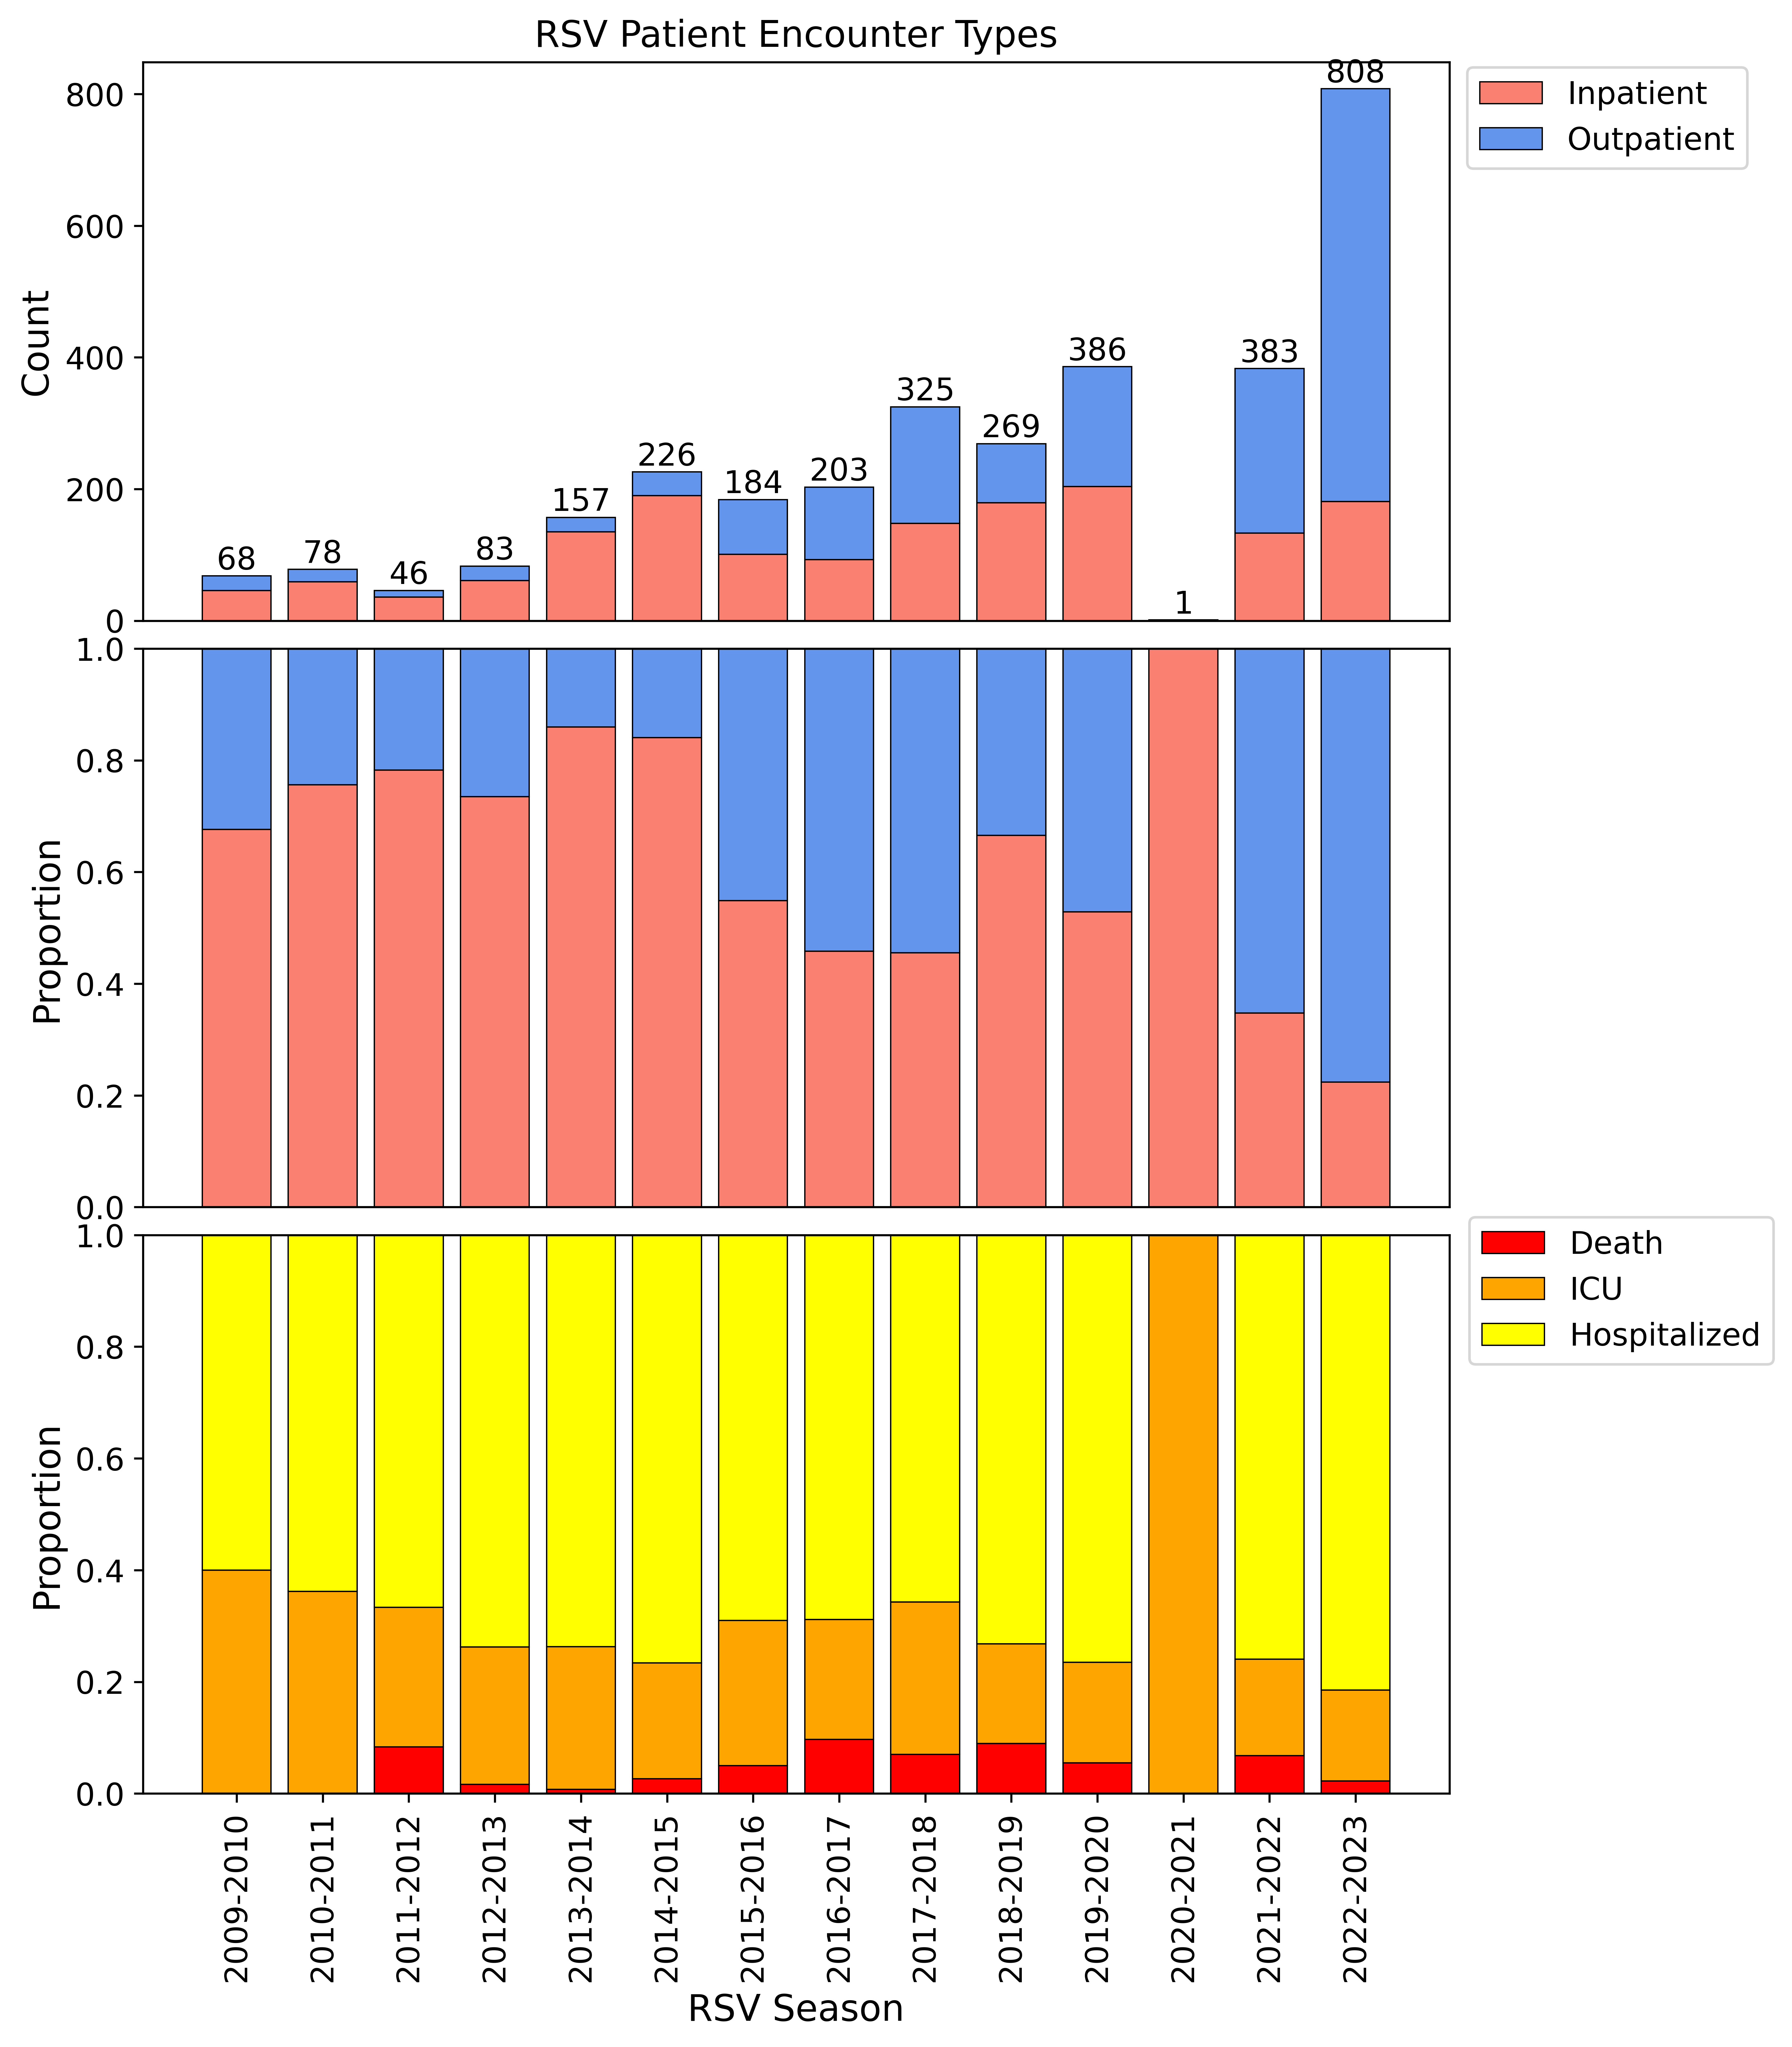

In [63]:
plt.figure(figsize=(9,12), dpi=600)
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(hspace=0.05)
plot1 = plt.subplot2grid((3, 1), (0, 0))
plot2 = plt.subplot2grid((3, 1), (1, 0))
plot3 = plt.subplot2grid((3, 1), (2, 0))

plot1.bar(x, y1b, color='salmon', label='Inpatient', edgecolor = "black", linewidth = 0.5)
plot1.bar(x, y1a, bottom= y1b, color='cornflowerblue', label='Outpatient', edgecolor = "black", linewidth = 0.5)
plot1.set_title('RSV Patient Encounter Types', fontsize=14)
plot1.set_xticks([])
plot1.set_ylabel('Count', fontsize=14)

plot1.legend(loc='right', bbox_to_anchor=(1.24, 0.9),
          ncol=1, fancybox=True, shadow=False)


bar_width = 10  # Width of each bar
bar_positions = range(len(x))  # Adjust the positions of the bars
# Adding up the total counts
totals = cat_count_prop.sum(axis=1)
y_offset = 10
# Add labels to each bar.
for i, total in enumerate(totals):
    plot1.text(bar_positions[i], total + y_offset, round(total), ha='center', weight='normal')


#plotting the proportion of RSV Patient Encounter Types
plot2.bar(x, y1bp, color='salmon', label='Death', edgecolor = "black", linewidth = 0.5)
ax2 = plot2.bar(x, y1ap, bottom= y1bp, color='cornflowerblue', label='ICU', edgecolor = "black", linewidth = 0.5)
plot2.set_xticks([])
plot2.set_ylabel('Proportion', fontsize=14)



#dropping Outpatients 
cat_counts_final2 = cat_counts_bottom.drop(columns=['Outpatient'])
#Calculating the percentage of values to get proportions in a stackplot
data_perc = cat_counts_final2.divide(cat_counts_final2.sum(axis=1), axis=0)

#proportional
y2p = data_perc['Hospitalized']
y3p = data_perc['ICU']
y4p = data_perc['Death']


plot3.bar(x, y4p, color='red', label='Death', edgecolor = "black", linewidth = 0.5)
plot3.bar(x, y3p, bottom= y4p, color='orange', label='ICU', edgecolor = "black", linewidth = 0.5)
plot3.bar(x, y2p, bottom=y3p+y4p, color='yellow', label='Hospitalized', edgecolor = "black", linewidth = 0.5)
x_ticks = ['2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019','2019-2020','2020-2021','2021-2022','2022-2023']  # Your x-axis tick labels
plot3.set_xticklabels(x_ticks, rotation=90)  # Rotate x-axis tick labels by 90 degrees
plot3.set_xlabel('RSV Season', fontsize=14)
plot3.set_ylabel('Proportion', fontsize=14)

plot3.legend(loc='right', bbox_to_anchor=(1.26, 0.9),
          ncol=1, fancybox=True, shadow=False)


#plt.savefig('090523-patient-encounter.svg', format='svg', bbox_inches='tight')

# Figure 2D: Diagnostic Panel and Testing Information

In [67]:
#List the unique diagnostics administered to the adult population
adlt_ND_boolean['procedure name'].unique()

array(['RSVDMB', 'RESP VIRUS PANEL MULTIPLEX PCR',
       'RESPIRATORY PATHOGEN PANEL (NAT)',
       'LOWER RESPIRATORY TRACT PANEL (NAT)',
       'RESPIRATORY PATHOGEN PANEL (NAT) WITH SARS-COV-2',
       'Respiratory Viral Panel by Multiplex PCR',
       'RAPID INFLUENZA A, B, RSV PCR (NMH/LFH)',
       'HB IRESPIRATORY MULTI PCR PANEL',
       '-RESPIRATORY PATHOGEN PANEL (NAT)', 'PNEPAN',
       'INFLUENZA A/B AND RSV,PCR (CDH/KH/VWH/NMH)', 'RESPAN',
       'Influenza A/B & RSV A/B Detection by PCR',
       'SARS-COV-2, INFLUENZA A/B, RSV PCR', 'RAPFLU',
       'INFLUENZA A/B RSV DETECTION',
       'RESPIRATORY PATHOGEN PANEL (NAT), SARS-COV-2',
       'ALINITY M RESP-4 PLEX ASSAY (NMH)', 'ALINITY M RESP-4 PLEX ASSAY',
       'RAPID INFUENZA A, B, RSV PCR - HX UPLOAD', 'RSV ANTIGEN',
       'RSV ANTIGEN (NWR/PH)', 'RESPIRATORY SYNCYTIAL VIRUS (RSV), DFA'],
      dtype=object)

In [64]:
#Grouping together the coded diagnostics into groupings (i.e. broad-spectrum, rapid, Ag, etc.)
mapping = {
    'RESPIRATORY PATHOGEN PANEL (NAT)': 'Respiratory Multiplex Platform - Panel [Broad]'
    'RSVAG': 'Other',
    'INFLUENZA A/B & RSV DETECTION BY PCR': 'Respiratory Multiplex Platform - Panel [Flu/RSV]',
    'RAPID INFLUENZA A, B, RSV PCR (NMH/LFH)': 'Respiratory Multiplex Platform - Rapid [Flu/RSV]',
    'RSV ANTIGEN (CDH/DCH)', 'Other'
    'INFLUENZA A/B AND RSV,PCR (CDH/KH/VWH/NMH)', 'Respiratory Multiplex Platform - Panel [Flu/RSV]'
}

In [95]:
#Setting up conversions to consolidate diagnostic groupings into (1) Multiplex Respiratory Panel 
#(2) Multiplex Respiratory Panel including SARS-CoV
diag_conv = {
    'RSVDMB' : 'Multiplex Respiratory Panel', 
    'RESP VIRUS PANEL MULTIPLEX PCR' : 'Multiplex Respiratory Panel',
       'RESPIRATORY PATHOGEN PANEL (NAT)' : 'Multiplex Respiratory Panel',
       'LOWER RESPIRATORY TRACT PANEL (NAT)': 'Multiplex Respiratory Panel',
       'RESPIRATORY PATHOGEN PANEL (NAT) WITH SARS-COV-2': 'Multiplex Respiratory Panel [+SARS-CoV-2]',
       'Respiratory Viral Panel by Multiplex PCR' : 'Multiplex Respiratory Panel',
       'RAPID INFLUENZA A, B, RSV PCR (NMH/LFH)' : 'Rapid Test [Influenza + RSV]',
       'HB IRESPIRATORY MULTI PCR PANEL': 'Multiplex Respiratory Panel',
       '-RESPIRATORY PATHOGEN PANEL (NAT)': 'Multiplex Respiratory Panel', 
     'PNEPAN': 'Multiplex Respiratory Panel',
       'INFLUENZA A/B AND RSV,PCR (CDH/KH/VWH/NMH)' : 'Multiplex Respiratory Panel [Influenza + RSV]', 
    'RESPAN' : 'Multiplex Respiratory Panel',
       'Influenza A/B & RSV A/B Detection by PCR': 'Rapid Test [Influenza + RSV]',
       'SARS-COV-2, INFLUENZA A/B, RSV PCR' : 'Rapid Test [Influenza + RSV + SARS-CoV-2]', 
    'RAPFLU': 'Rapid Test [Influenza + RSV]',
       'INFLUENZA A/B RSV DETECTION': 'Multiplex Respiratory Panel [Influenza + RSV]',
       'RESPIRATORY PATHOGEN PANEL (NAT), SARS-COV-2': 'Multiplex Respiratory Panel [+SARS-CoV-2]',
       'ALINITY M RESP-4 PLEX ASSAY (NMH)' : 'Multiplex Respiratory Panel [+SARS-CoV-2]',
    'ALINITY M RESP-4 PLEX ASSAY' : 'Multiplex Respiratory Panel [+SARS-CoV-2]',
       'RAPID INFUENZA A, B, RSV PCR - HX UPLOAD': "Rapid Test [Influenza + RSV]", 
    'RSV ANTIGEN' : 'Other',
       'RSV ANTIGEN (NWR/PH)' : 'Other', 
    'RESPIRATORY SYNCYTIAL VIRUS (RSV), DFA' : 'Other'
}

In [96]:
#Creating a 'diagnostic_group' category to condense grouping
adlt_ND_boolean['diagnostic_group'] = adlt_ND_boolean['procedure name'].map(diag_conv)

# For procedures not in the mapping, set 'Other' as the default value
adlt_ND_boolean['diagnostic_group'].fillna('Other', inplace=True)

In [98]:
adlt_ND_boolean['diagnostic_group'].unique()

array(['Multiplex Respiratory Panel',
       'Multiplex Respiratory Panel [+SARS-CoV-2]',
       'Rapid Test [Influenza + RSV]',
       'Multiplex Respiratory Panel [Influenza + RSV]',
       'Rapid Test [Influenza + RSV + SARS-CoV-2]', 'Other'], dtype=object)

In [110]:
#Assigning the different groups to their own respective dataframes

FluRSV = adlt_ND_boolean[adlt_ND_boolean['diagnostic_group'] == 'Multiplex Respiratory Panel']
a = FluRSV[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Multiplex Respiratory Panel')

Multi = adlt_ND_boolean[adlt_ND_boolean['diagnostic_group'] == 'Multiplex Respiratory Panel [+SARS-CoV-2]']
b = Multi[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Multiplex Respiratory Panel [+SARS-CoV-2]')

FluRSVCoV = adlt_ND_boolean[adlt_ND_boolean['diagnostic_group'] == 'Rapid Test [Influenza + RSV]']
c = FluRSVCoV[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Rapid Test [Influenza + RSV]')

Other = adlt_ND_boolean[adlt_ND_boolean['diagnostic_group'] == 'Multiplex Respiratory Panel [Influenza + RSV]']
d = Other[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Multiplex Respiratory Panel [Influenza + RSV]')

RSV = adlt_ND_boolean[adlt_ND_boolean['diagnostic_group'] == 'Rapid Test [Influenza + RSV + SARS-CoV-2]']
e = RSV[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Rapid Test [Influenza + RSV + SARS-CoV-2]')

RSV2 = adlt_ND_boolean[adlt_ND_boolean['diagnostic_group'] == 'Other']
f = RSV2[['ir_id','season']].groupby(['season'])['season'].size().reset_index(name='Other')


In [111]:
cat_count = pd.merge(a,b, on='season', how='outer').fillna(0)
cat_count1 = pd.merge(cat_count, c, on='season', how='outer').fillna(0)
cat_count2 = pd.merge(cat_count1, d, on='season', how='outer').fillna(0)
cat_count3 = pd.merge(cat_count2, e, on='season', how='outer').fillna(0)
cat_count6 = pd.merge(cat_count3, f, on='season', how='outer').fillna(0)
cat_count6 = cat_count6.sort_values(by='season')

#dropping column to get percentages
cat_count6 = cat_count6.drop(columns=['season'])

#Calculating the percentage of values to get proportions in a stackplot
data_perc = cat_count6.divide(cat_count6.sum(axis=1), axis=0)


cat_count6 = cat_count6.astype(float)
data_perc = data_perc.astype(float)


Text(0, 0.5, 'Proportion')

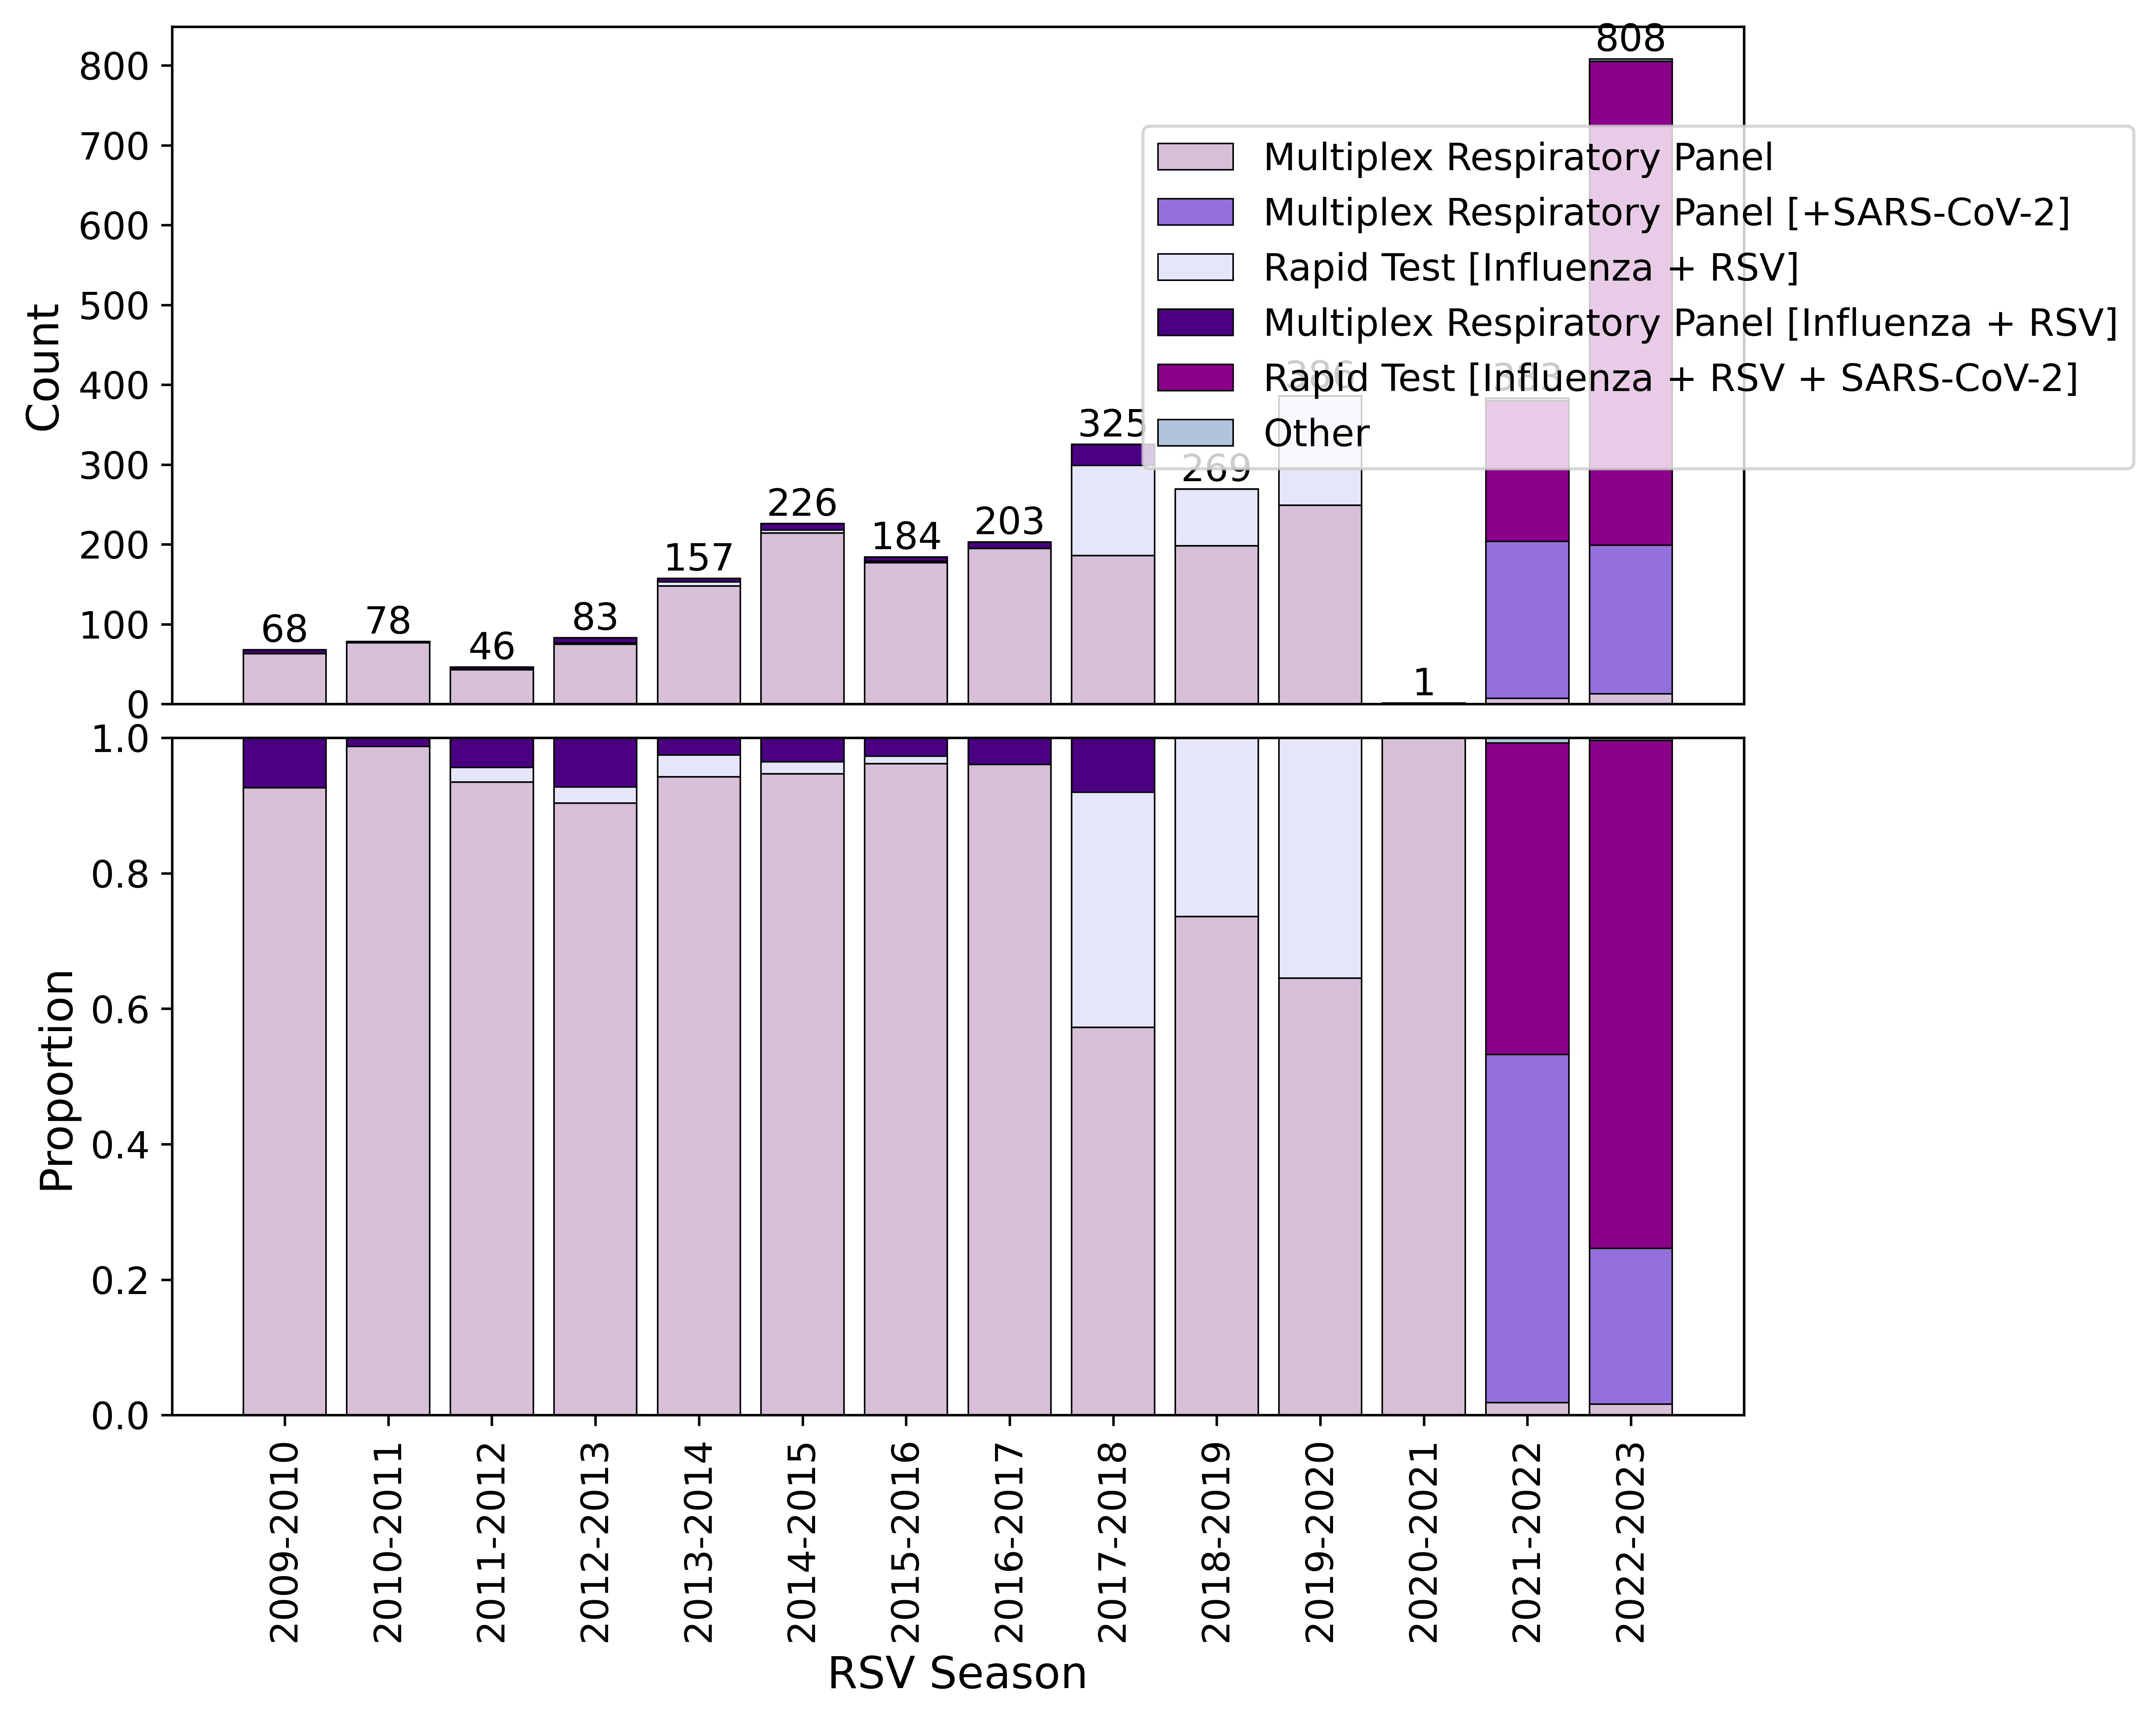

In [114]:
plt.figure(figsize=(9,8), dpi=600)
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(hspace=0.05)
plot1 = plt.subplot2grid((2, 1), (0, 0)) 
plot2 = plt.subplot2grid((2, 1), (1, 0))  

x = cat_count3['season']

color_palette = ['thistle', 'mediumpurple', 'lavender', 'indigo', 'darkmagenta', 'lightsteelblue', 'pink']

y1 = cat_count6['Multiplex Respiratory Panel']
y2 = cat_count6['Multiplex Respiratory Panel [+SARS-CoV-2]']
y3 = cat_count6['Rapid Test [Influenza + RSV]']
y4 = cat_count6['Multiplex Respiratory Panel [Influenza + RSV]']
y5 = cat_count6['Rapid Test [Influenza + RSV + SARS-CoV-2]']
y6 = cat_count6['Other']

plot1.bar(x, y1, edgecolor = "black", linewidth = 0.5, color=color_palette[0] )
plot1.bar(x, y2, bottom=y1, edgecolor = "black", linewidth = 0.5, color=color_palette[1] )
plot1.bar(x, y3, bottom= y1+y2, edgecolor = "black", linewidth = 0.5, color=color_palette[2])
plot1.bar(x, y4, bottom= y1+y2+y3,  edgecolor = "black", linewidth = 0.5, color=color_palette[3])
plot1.bar(x, y5, bottom=y1+y2+y3+y4,  edgecolor = "black", linewidth = 0.5, color=color_palette[4])
plot1.bar(x, y6, bottom=y1+y2+y3+y4+y5, edgecolor = "black", linewidth = 0.5, color=color_palette[5])

plot1.set_xticks([])
plot1.set_ylabel('Count', fontsize=14)

legend_labels = [
    'Multiplex Respiratory Panel',
       'Multiplex Respiratory Panel [+SARS-CoV-2]',
       'Rapid Test [Influenza + RSV]',
       'Multiplex Respiratory Panel [Influenza + RSV]',
       'Rapid Test [Influenza + RSV + SARS-CoV-2]', 'Other']

# Create the legend
plot1.legend(legend_labels, loc='right', bbox_to_anchor=(1.26, 0.6),
          ncol=1, fancybox=True, shadow=False)

bar_width = 10  # Width of each bar
bar_positions = range(len(x))  # Adjust the positions of the bars
#Adding up the total counts
totals = cat_count6.sum(axis=1)
y_offset = 10
# Add labels to each bar.
for i, total in enumerate(totals):
    plot1.text(bar_positions[i], total + y_offset, round(total), ha='center', weight='normal')
    
y1 = data_perc['Multiplex Respiratory Panel']
y2 = data_perc['Multiplex Respiratory Panel [+SARS-CoV-2]']
y3 = data_perc['Rapid Test [Influenza + RSV]']
y4 = data_perc['Multiplex Respiratory Panel [Influenza + RSV]']
y5 = data_perc['Rapid Test [Influenza + RSV + SARS-CoV-2]']
y6 = data_perc['Other']

plot2.bar(x, y1, edgecolor = "black", linewidth = 0.5, color=color_palette[0] )
plot2.bar(x, y2, bottom=y1, edgecolor = "black", linewidth = 0.5, color=color_palette[1] )
plot2.bar(x, y3, bottom= y1+y2, edgecolor = "black", linewidth = 0.5, color=color_palette[2])
plot2.bar(x, y4, bottom= y1+y2+y3,  edgecolor = "black", linewidth = 0.5, color=color_palette[3])
plot2.bar(x, y5, bottom=y1+y2+y3+y4,  edgecolor = "black", linewidth = 0.5, color=color_palette[4])
plot2.bar(x, y6, bottom=y1+y2+y3+y4+y5, edgecolor = "black", linewidth = 0.5, color=color_palette[5])

x_ticks = ['2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019','2019-2020','2020-2021','2021-2022','2022-2023']  # Your x-axis tick labels
plot2.set_xticks(range(len(x_ticks)))
plot2.set_xticklabels(x_ticks, rotation=90)  # Rotate x-axis tick labels by 90 degrees
plot2.set_xlabel('RSV Season', fontsize=14)
plot2.set_ylabel('Proportion', fontsize=14)

#plt.savefig('090523-testing-encounter.svg', format='svg', bbox_inches='tight')